In [8]:
import json
import pandas as pd
import requests
import datetime
from binance import Client
import matplotlib.pyplot as plt
import numpy as np
import os
from binance.client import Client
import datetime, time
from datetime import datetime
from numba import jit

# Бэктест_начало


In [9]:
# Требуется собрать данные в датафрейм df 
# Задаем даты начала и конца бектеста
start_date = '11/05/2022'
end_date = '11/08/2022'
# interval = '5 min' # '15 min', '30 min'

def GetHistoricalData(symbol, interval, fromDate, toDate):
    klines = client.get_historical_klines(symbol, interval, fromDate, toDate)
    df = pd.DataFrame(klines, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms')
    df['date'] = df.dateTime.dt.strftime("%d/%m/%Y")
    df['time'] = df.dateTime.dt.strftime("%H:%M:%S")
    df = df.drop(['dateTime', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)
    column_names = ["date", "time", "open", "high", "low", "volume"]
    df = df.reindex(columns=column_names)
    return df
    
api_key = ""
api_secret = ""
client = Client(api_key, api_secret)


fromDate = str(datetime.strptime(start_date, '%d/%m/%Y'))
toDate = str(datetime.strptime(end_date, '%d/%m/%Y'))
symbol = "ETHUSDT"
interval = Client.KLINE_INTERVAL_5MINUTE
df = GetHistoricalData(symbol, interval, fromDate, toDate)

## Определим 3 функции прибыли:  
Пока они вне класса, нужно внести их. 


In [10]:
def unforward_earnings(start_price, end_price, high_board, low_board):
    """Функция должна получить всю необходимую информацию и возвратить итоговую прибыль-убыток в пуле.
    Тут не учитываются заработанные комиссии. Только изменение стоимости токенов и их соотношение.
    Внимание!!!! Тут есть допущения - вкладываются равные части вверх и вниз"""
    # Если после 24(или другого) периода цена оказалась выше изначальной
    if end_price >= start_price:
        res =  ((min(end_price, high_board)-start_price)/2+start_price)/start_price*0.5+0.5
    elif end_price < start_price:
        res =  (0.5/((start_price - max(end_price, low_board))/2 + max(end_price, low_board)) + 0.5/start_price)*end_price
    return (res-1)*100 # возвращаем результат в процентах!

def simple_hedge(start_price, end_price, ratio):
    '''Данная функция принимает начальную и конечную стоимость. А так же параметры хеджирования - долю хеджа
    Возвращает процентный заработок/убыток из за хеджа в % от всех инвестиций(не только захеджированных)'''
    res = -(end_price-start_price)/start_price
    return res*100*ratio

def persentage_earnings(const=1):
    '''Функция принимает необходимые параметры и рассчитывает доходность в % от всех изначальных инвестиций
    Для начала используем константу - 1%'''
    res = const
    return res
    


In [11]:
unforward_earnings(100, 120, 140, 90)

5.000000000000004

In [12]:
################### Инициализация параметров обучения ######################
n_info = 24 # часов для обучения (не совсем обучение, скорее зависимая часть)
n_forcast = 24 # на какой период предсказываем
intervals_in_hour = 12 # какими интервалами оперируем здесь 12 - 5 минутки

In [13]:
# Класс который принимаем в себя всю необходимую информацию и подготавливает данные, рассчитывает интервалы и тп
class Interval_calculator:
    def __init__(self, df, n_info, n_forcast, intervals_in_hour):
        self.df = df
        self.n_info = n_info
        self.n_forcast = n_forcast
        self.intervals_in_hour = intervals_in_hour
        self.make_new_col()
        self.preob()
        self.calculate_intervals()
        self.make_data_for_back()
        self.get_periodic()
        
    def make_new_col(self):
        '''Потребуются относительные изменения'''
        print('Добавляю относительные изменения')
        df = self.df
        mass = np.zeros(len(df))
        mass[0] = 1 # первую точку доопределяем 1
        values = df['open'].values.astype(float)
        for i in range(1, len(df)):
            mass[i] = values[i]/values[i-1]
            df['change'] = mass
        self.df = df
        return    
        
        
    def preob(self):
        '''Функция просто создает кучу разбивок для бутстрэпа и предсказания
        df - датасет
        n_info - сколько часов брать для "обучения"
        n_forcast - на сколько часов давать прогноз
        intervals_in_hour - количество выбранных интерваллов в часе (если минутные данные то 60)
        '''
        print('Создаю разбивку - данные для рассчета интервала и теста')
        df, n_info, n_forcast, intervals_in_hour = self.df, self.n_info, self.n_forcast, self.intervals_in_hour
        self.dict_res = {}
        for i in range(n_info*intervals_in_hour, len(df)-n_forcast*intervals_in_hour):
            fold_info = df[i-n_info*intervals_in_hour : i] # Срез датасета
            fold_res = df[i : i+n_forcast*intervals_in_hour] # Срез датасета
            self.dict_res[i] = [fold_info, fold_res] # В словаре лежат два датасета под каждым ключом
        return 
    
    @jit
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
        '''Функция бутстрэпит изменения за прошедшие часы (это длина массива) n_forcast*intervals_in_hour раз, 
        процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
        mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
        mass = np.array(mass) # переводим в numpy
        n = len(mass) # длина выборки для обучения
        size_forecast = n_forcast*intervals_in_hour
        # случайно берем числа до n, размера n_forcast*intervals_in_hour
        indexes = np.random.randint(n, size=size_forecast*10000)
        change = mass[[indexes]]
        change = change.reshape((10000, size_forecast))
        # теперь рассомтрим куммулятивное перемножение- предсказанное поведение
        cum_change = np.cumprod(change, axis=1)
        # минимальное и максимальные значения внутри временного интервалла
        min_ = np.min(cum_change, axis=1)
        max_ = np.max(cum_change, axis=1)
        sorted_res_min = np.sort(min_)
        sorted_res_max = np.sort(max_)
        high, low = sorted_res_max[9500], sorted_res_min[500]
        return np.array([high, low])
    
    def get_real(self, df):
      '''Функция нужна для валидации - возвращает верхние и нижние границы'''
      high = (df['high'].values.astype(float))
      low = (df['low'].values.astype(float))
      return np.hstack([high, low])
    
    def calculate_intervals(self):
        print('Рассчитываю интерваллы')
        dict_res, n_forcast, intervals_in_hour = self.dict_res, self.n_forcast, self.intervals_in_hour
        calculated_intervals = np.zeros((len(dict_res), 2))
        real_intervals = np.zeros((len(dict_res), n_forcast*intervals_in_hour*2)) # запоминаем  всю динамику  умножение на 2 тк записываем для верха и для низа
        k = 0
        for key in dict_res:
            real_intervals[k, :] = self.get_real(dict_res[key][1])

            # требуется для абсолютных значений запомнить цену открытия
            last_value = dict_res[key][0]['open'].values.astype(float)[-1]

            calculated = self.bootstrap(dict_res[key][0]['change'].values, n_forcast, intervals_in_hour)

            calculated_intervals[k, 0:2] = calculated*last_value

            k += 1
            j = int(len(dict_res)/200)
            if k % j == 0:
                print('progress = {} %'.format(round(k/len(dict_res)*100, 3)))
        self.intervals = calculated_intervals, real_intervals
        return

    def make_data_for_back(self):
        print('Преобразую данные для бэктеста')
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        # mass high, low, start, end
        k_end = n_forcast*intervals_in_hour-1
        mass = np.zeros((len(intervals[0]), 4))
        for i in range(len(intervals[0])):
            mass[i, :] = *intervals[0][i] , intervals[1][i][0], intervals[1][i][k_end]
    #         intervals[0][i] - high, low
    #         intervals[1][i][0] - start
    #         intervals[1][i][k] - end
        self.data_for_back = mass
        return

    def make_data_for_back(self):
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        # mass high, low, start, end
        k_end = n_forcast*intervals_in_hour-1
        mass = np.zeros((len(intervals[0]), 4))
        for i in range(len(intervals[0])):
            mass[i, :] = *intervals[0][i] , intervals[1][i][0], intervals[1][i][k_end]
    #         intervals[0][i] - high, low
    #         intervals[1][i][0] - start
    #         intervals[1][i][k] - end
        self.data_for_back = mass
        return
    
    def dynamic_hedge(self, i, price_for_f=0.1, hedge_activation=0.01):
        all_sum = 0
        hedge_activated = 0
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        i = i*n_forcast*intervals_in_hour
        start_price = intervals[1][i][0]
        end_price = intervals[1][i][intervals_in_hour*n_forcast-1]
        highs = intervals[1][i][:intervals_in_hour*n_forcast]
        lows = intervals[1][i][intervals_in_hour*n_forcast:]
        for j in range(len(highs)):
            # Если нет хеджа и цена пошла вниз, открываем позицию, платим премию
            if hedge_activated == 0 and lows[j] < (1-hedge_activation)*start_price:
                hedge_activated = 1
                all_sum -= price_for_f
            # Если цена пошла вверх, нужно закрыть хедж если он существует, заплатив за это
            elif hedge_activated == 1 and highs[j] > (1+hedge_activation)*start_price:
                hedge_activated = 0
                all_sum += -(highs[j]-start_price*(1-hedge_activation))/start_price*100
        if hedge_activated == 1:
            all_sum += -(end_price-start_price*(1-hedge_activation))/start_price*100
        
        return all_sum
    
    def option_hedge(self, i, price_o = 0, strike=0.99):
        '''Данная функция принимает стоимость опциона, и выдает конечную прибыль или убыток
        , убыток не больше стоимости опциона. Стоимость опциона выражается в процентах'''
        start = self.periodic_data_for_back[i, :][2]
        end = self.periodic_data_for_back[i, :][3]
        # затраты на опцион
        res = -price_o
        # покупаем опицон со страйком strike = 0.99 от цены старта, если цена ушла ниже страйка то добавляем прибыль
        if start*strike > end:
            res += (start*strike-end)/start*100 # результат в процентах
        return res
        
    
    def get_periodic(self):
        data_for_back, n_forcast, intervals_in_hour = self.data_for_back, self.n_forcast, self.intervals_in_hour
        '''Просто обрезка, выбор каждого n часового результата'''
        self.periodic_data_for_back = data_for_back[::n_forcast*intervals_in_hour, :]
        return 
    
    def back_test(self, ratio_for_hedge, hadge_type='simple', dyn_price=0.1, hedge_activation=0.01,  const_earnings=1,
                 price_o=0, strike=0.99):
        '''Функция проводит анализ стратегии, возвращает список прибыли/убытков в каждый период'''
        mass_for_back, n_forcast = self.periodic_data_for_back, self.n_forcast
        earnings = np.zeros(len(mass_for_back))
#         print(ratio_for_hedge, hadge_type)
        for i in range(len(mass_for_back)):
            high_board, low_board, start_price, end_price = mass_for_back[i, :]

            e1 = unforward_earnings(start_price, end_price, high_board, low_board)
            # тут есть допущение - хедж для нас не требует блокировку активов - фьючерсы в общем ,причем бесплатные
            if hadge_type == 'simple':
                e2 = simple_hedge(start_price, end_price, ratio_for_hedge)
            elif hadge_type == 'f':
                e2 = self.dynamic_hedge(i, price_for_f=dyn_price, hedge_activation=hedge_activation)
            elif hadge_type == 'o':
                e2 = self.option_hedge(i, price_o=price_o, strike=strike)
            e3 = persentage_earnings(const_earnings)*n_forcast/24
            earnings[i] = e1+e2+e3
        return earnings
    
    
    def plot_results(self, hedges, add_dynamic=False, add_o=False, dyn_price=0.1, hedge_activation=0.01, const_earnings=1, price_o=0, strike=0.99):
        fig = plt.figure(figsize = (10, 10))
        mass_for_back = self.periodic_data_for_back
        x = range(0, len(mass_for_back)*8, 8)
    #     x = range(0, len(mass_for_back))
        for hedge in hedges:
            earnings = self.back_test(hedge, const_earnings=const_earnings)
            y = np.cumsum(earnings)
            plt.plot(x, y, label = 'hedge = {}'.format(hedge))
            plt.xlabel('Время в часах с начала стратегии', fontsize=15)
            plt.ylabel('Доходность в %', fontsize=15)
            plt.title('Анализ итоговой доходности при использовании стратегии', fontsize = 15)
        if add_dynamic:
            earnings = self.back_test(0, hadge_type='f', dyn_price=dyn_price, hedge_activation=hedge_activation, 
                                      const_earnings=const_earnings)
            y = np.cumsum(earnings)
            plt.plot(x, y, label = 'dynamic_hedge')
        if add_o:
            earnings = self.back_test(0, hadge_type='o', price_o=price_o, strike=strike)
            y = np.cumsum(earnings)
            plt.plot(x, y, label = 'option')
        plt.legend(prop={'size': 10})
        
    def plot_price(self):
        # Просто отрисовка того, как изменялся курс, чтобы интерпретировать прибыли и убытки в стратегии
        mass_for_back = self.periodic_data_for_back
        fig = plt.figure(figsize = (10, 10))
        plt.plot(mass_for_back[:, 3])
        plt.title('Курс ETH/USDT')
        
    def change_price_distr(self):
        mass_for_back = self.periodic_data_for_back
        change = np.zeros(len(mass_for_back))
        starts = mass_for_back[:, 2]
        ends = mass_for_back[:, 3]
        for i in range(len(change)):
            end = ends[i]
            start = starts[i]
            res = (end - start)/start*100 # итог в процентах +10% или -0.5%
            change[i] = res
        fig = plt.figure(figsize = (10, 10))
        plt.xlabel('Изменение стоимости в %', fontsize=15)
        plt.hist(change, bins=15)
        plt.show()

    


In [14]:
back_test_obj = Interval_calculator(df, n_info, n_forcast, intervals_in_hour)

Добавляю относительные изменения
Создаю разбивку - данные для рассчета интервала и теста
Рассчитываю интерваллы


<ipython-input-13-bbc68887b0a8>:44: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bootstrap" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-13-bbc68887b0a8> (48)

File "<ipython-input-13-bbc68887b0a8>", line 48:
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
        <source elided>
        процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
        mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
        ^

  @jit
/Users/vladislav705/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "bootstrap" was compiled in object mode without forceobj=True.

File "<ipython-input-13-bbc68887b0a8>", line 45:
    @jit
    def bootstrap(self, mass, n_forcast, intervals_in_hour):
    ^

  warnings.warn(errors.N

progress = 0.498 %
progress = 0.995 %
progress = 1.493 %
progress = 1.991 %
progress = 2.488 %
progress = 2.986 %
progress = 3.484 %
progress = 3.981 %
progress = 4.479 %
progress = 4.977 %
progress = 5.474 %
progress = 5.972 %
progress = 6.47 %
progress = 6.967 %
progress = 7.465 %
progress = 7.963 %
progress = 8.46 %
progress = 8.958 %
progress = 9.456 %
progress = 9.953 %
progress = 10.451 %
progress = 10.949 %
progress = 11.446 %
progress = 11.944 %
progress = 12.442 %
progress = 12.939 %
progress = 13.437 %
progress = 13.935 %
progress = 14.432 %
progress = 14.93 %
progress = 15.428 %
progress = 15.925 %
progress = 16.423 %
progress = 16.921 %
progress = 17.418 %
progress = 17.916 %
progress = 18.414 %
progress = 18.911 %
progress = 19.409 %
progress = 19.907 %
progress = 20.404 %
progress = 20.902 %
progress = 21.4 %
progress = 21.897 %
progress = 22.395 %
progress = 22.893 %
progress = 23.39 %
progress = 23.888 %
progress = 24.386 %
progress = 24.883 %
progress = 25.381 %
progre

In [28]:
hedges = [0, 0.1, 1]

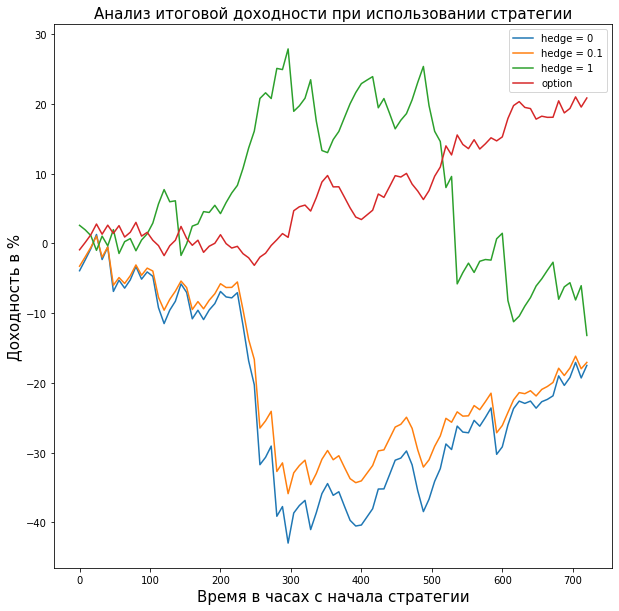

In [38]:
back_test_obj.plot_results(hedges, add_dynamic=False, dyn_price=0.1, hedge_activation=0.05, add_o=True,
                 price_o=0.5, strike=0.97)

### Рассмотрим как изменялся курс ETH/USDT

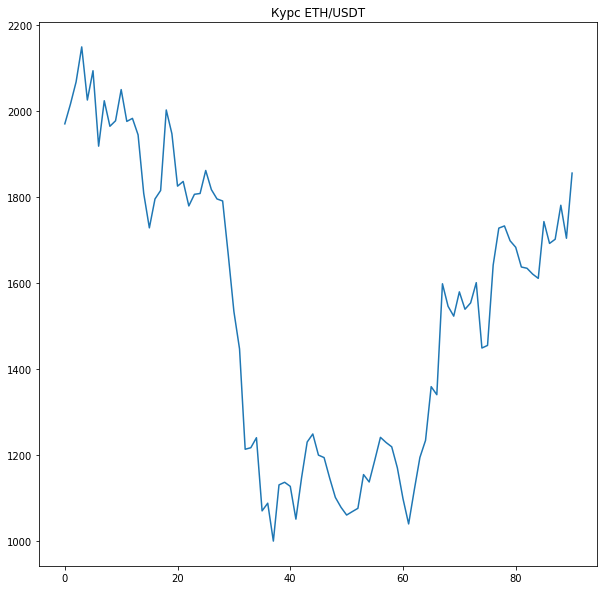

In [18]:
back_test_obj.plot_price()

### Дополнительно проверим как распределены изменения в стоимости (после 24 часов)¶


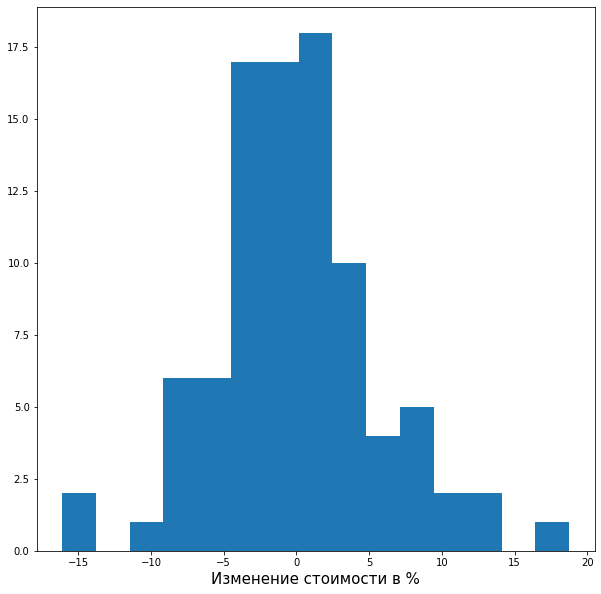

In [39]:
back_test_obj.change_price_distr()

### Дополнительно проверим как распределены изменения в стоимости (после 8 часов)¶

# Все что ниже игнорировать!

# Все что ниже игнорировать!

# Все что ниже игнорировать!

# Все что ниже игнорировать!

# Все что ниже игнорировать!

In [108]:
i = 2

In [109]:
back_test_obj.dynamic_hedge(i, price_for_f=0.1)

2.409423997960405

In [110]:
j = i*96

In [111]:
back_test_obj.data_for_back[j,:]

array([1101.25212149, 1015.66736684, 1081.54      , 1039.12      ])

In [112]:
back_test_obj.periodic_data_for_back[i, :]

array([1101.25212149, 1015.66736684, 1081.54      , 1039.12      ])

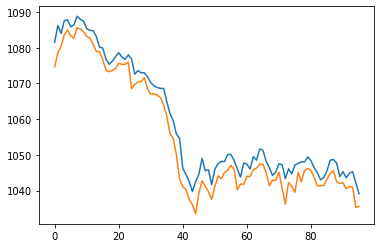

In [113]:

highs = back_test_obj.intervals[1][j][:96]
lows = back_test_obj.intervals[1][j][96:]
plt.plot(highs)
plt.plot(lows)

In [114]:
intervals = back_test_obj.intervals

In [115]:
highs = intervals[1][j][:intervals_in_hour*n_forcast]
lows = intervals[1][j][intervals_in_hour*n_forcast:]
start_price = intervals[1][j][0]
end_price = intervals[1][j][intervals_in_hour*n_forcast-1]
hedge_activated = 0
all_sum = 0
dict_dots = {}
for k in range(len(highs)):
    if hedge_activated == 0 and lows[k] < 0.99*start_price:
        hedge_activated = 1
        all_sum -= price_for_f
        dict_dots[k] = lows[k]
    elif hedge_activated == 1 and highs[k] > 1.01*start_price:
        hedge_activated = 0
        dict_dots[k] = highs[k]
print(all_sum)
if hedge_activated == 1:
    all_sum += -(end_price-start_price*0.99)/start_price*100
    

-0.1


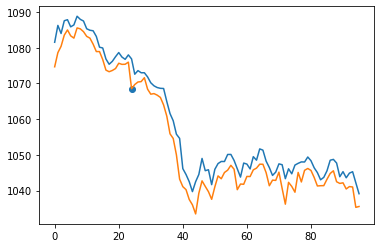

In [116]:
highs = back_test_obj.intervals[1][j][:96]
lows = back_test_obj.intervals[1][j][96:]
plt.plot(highs)
plt.plot(lows)
for key in dict_dots:
    plt.scatter([key], dict_dots[key])

In [41]:
price_for_f = 0.1
all_sum = 0
hedge_activated = 0
i = 160
intervals = back_test_obj.intervals
n_forcast = 8
intervals_in_hour = 12

start_price = intervals[1][i][0]
end_price = intervals[1][i][intervals_in_hour*n_forcast-1]
highs = intervals[1][i][:intervals_in_hour*n_forcast]
lows = intervals[1][i][intervals_in_hour*n_forcast:]
for j in range(len(highs)):
    if hedge_activated == 0 and lows[j] < 0.99*start_price:
        hedge_activated = 1
        all_sum -= price_for_f
    elif hedge_activated == 1 and highs[j] > 1.01*start_price:
        hedge_activated = 0
print(all_sum)
if hedge_activated == 1:
    all_sum += -(end_price-start_price)/start_price*100

print(all_sum)

-0.1
0.9307387980085323


In [ ]:
def dynamic_hedge(self, i, price_for_f=0.1):
        all_sum = 0
        hedge_activated = 0
        intervals, n_forcast, intervals_in_hour = self.intervals, self.n_forcast, self.intervals_in_hour
        start_price = intervals[1][i][0]
        end_price = intervals[1][i][intervals_in_hour*n_forcast-1]
        highs = intervals[1][i][:intervals_in_hour*n_forcast]
        lows = intervals[1][i][intervals_in_hour*n_forcast:]
        for j in range(len(highs)):
            if hedge_activated == 0 and lows[j] < 0.99*start_price:
                hedge_activated = 1
                all_sum -= price_for_f
            elif hedge_activated == 1 and highs[j] > 1.01*start_price:
                hedge_activated = 0
        if hedge_activated == 1:
            all_sum += -(end_price-start_price)/start_price*100
        
        return all_sum

### проверка логики работы

In [58]:
start_price = 1600

high_board = 1700
low_board = 1500

end_price = 500

n_forcast = 8
ratio_for_hedge = 1
e1 = unforward_earnings(start_price, end_price, high_board, low_board)
# тут есть допущение - хедж для нас не требует блокировку активов - фьючерсы в общем , причем бесплатные
e2 = simple_hedge(start_price, end_price, ratio_for_hedge)
e3 = persentage_earnings()*n_forcast/24

In [59]:
print(e1, ' Заработок внутри пула')
print(e2, ' Заработок от хеджа')
print(e3, ' Процентный заработок')
print(e1+e2+e3, "Итог")

-68.24596774193547  Заработок внутри пула
68.75  Заработок от хеджа
0.3333333333333333  Процентный заработок
0.8373655913978599 Итог
